In [13]:
import pandas as pd
import plotly

# Read the CSV filed
df = pd.read_excel('./data/lookout.xlsx')  # Assuming tab-separated based on your image


In [14]:
df

,Dag,Date,P,T,Q,PET,Unnamed: 6,Unnamed: 7,Unnamed: 8,month,PETmean,Tmean,CET
0,19510601,1951-06-01,0.0,10.40,2.234137,0.50,NaN,NaN,NaN,1.0,0.50,1.429508,1.0
1,19510602,1951-06-02,0.0,11.20,2.155746,1.00,NaN,NaN,NaN,2.0,1.00,2.954411,NaN
2,19510603,1951-06-03,0.0,11.15,2.116550,1.73,NaN,NaN,NaN,3.0,1.73,4.383011,NaN
3,19510604,1951-06-04,0.0,8.65,2.038160,2.59,NaN,NaN,NaN,4.0,2.59,7.639000,NaN
4,19510605,1951-06-05,0.0,13.35,1.959769,3.65,NaN,NaN,NaN,5.0,3.65,12.017950,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17284,19980926,1998-09-26,0.0,8.90,0.548735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17285,19980927,1998-09-27,0.0,10.85,0.376276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17286,19980928,1998-09-28,0.0,12.50,0.337080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17287,19980929,1998-09-29,0.0,12.80,0.325322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Import the model
from hbv_model import HBVModel
from calibration import calibrate_hbv_model  # function to do the calibration
import pandas as pd


# 1. Initialize the model
model = HBVModel()

# # 2. Load your data (either from file or DataFrame)
# # Read the data from pandas df
model.load_data(data=df,
               date_column='Dag',
               precip_column='P',
               temp_column='T',
               pet_column='PET',
               obs_q_column='Q',
               date_format='%Y%m%d',
               start_date='1982-01-15',          # start date you want
               end_date='1983-01-15',
            )  # if you have observed discharge




Detected 12 PET values (monthly means), expanding to daily values...
Time step detected: D
Loaded data with 366 time steps, from 1982-01-15 00:00:00 to 1983-01-15 00:00:00


In [9]:
import matplotlib.pyplot as plt 
model.data

,Dag,Date,P,T,Q,Unnamed: 6,Unnamed: 7,Unnamed: 8,month,PETmean,Tmean,CET,PET
0,1982-01-15,1982-01-15,0.0,0.85,2.939653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
1,1982-01-16,1982-01-16,37.8,1.10,3.723561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
2,1982-01-17,1982-01-17,30.5,1.65,13.326429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
3,1982-01-18,1982-01-18,13.5,0.55,9.406891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
4,1982-01-19,1982-01-19,0.3,0.55,5.879307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,1983-01-11,1983-01-11,0.0,3.05,10.347580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
362,1983-01-12,1983-01-12,0.0,2.75,9.602868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
363,1983-01-13,1983-01-13,0.0,1.65,8.662179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
364,1983-01-14,1983-01-14,0.0,2.25,6.114479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5


In [10]:

custom_params = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.3, 'max': 1.5, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 650, 'default': 450.0},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.01, 'max': 0.9, 'default': 0.12},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.05},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.005, 'max': 0.5, 'default': 0.05},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},    # Upper zone threshold (mm)
        'PERC': {'min': 0.03, 'max': 25, 'default': 0.25}     # Percolation rate (mm/day)
    }
}
model.set_parameters(custom_params)

#4. Set initial conditions (optional - uses defaults if not set)
model.set_initial_conditions(
    snowpack=0,  #initial snowpack (mm)
    liquid_water=0,    # Initial liquid water in snow (mm)
    soil_moisture= 650,  # Initial soil moisture (mm)
    upper_storage=80,   # Initial upper zone storage (mm)
    lower_storage=30, ) # Initial lower zone storage (mm)

# 5. Run the model
results = model.run()

Initial conditions updated.
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.237
KGE: 0.369
PBIAS: -39.6%
Correlation: 0.583


Figure saved to fig.png


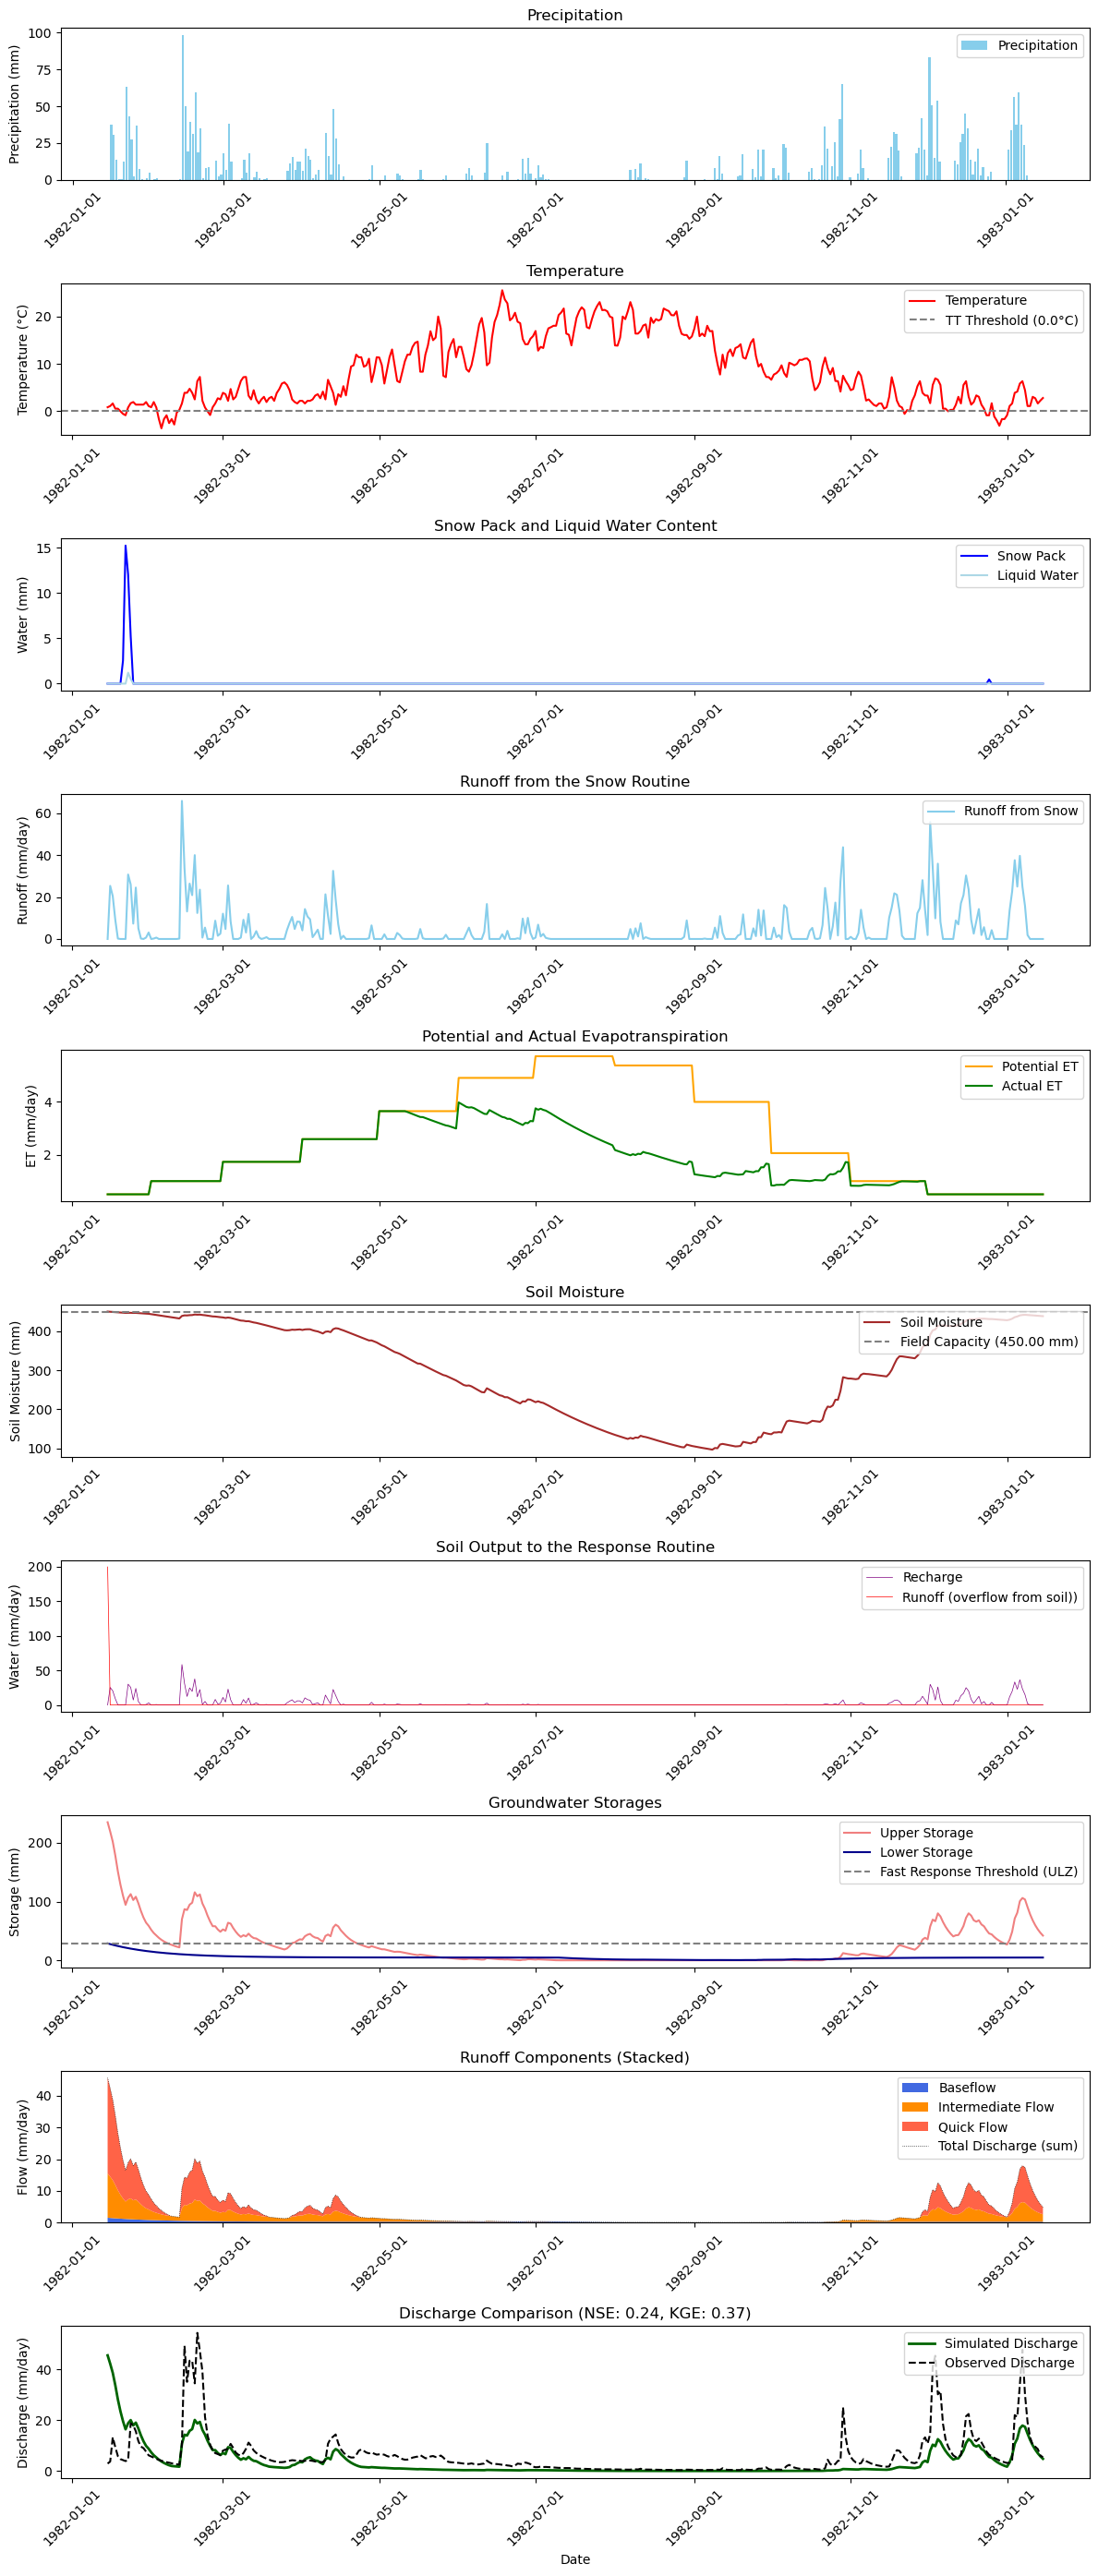

In [11]:
# #6. Visualize results
model.plot_results(output_file='fig.png')

#7. Save results to CSV (optional)
#model.save_results("./results/hbv_uncalibrated_results.csv")

Starting calibration using SLSQP method...
Optimizing NSE with 14 parameters and 5000000 iterations
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.448
KGE: 0.253
PBIAS: -52.0%
Correlation: 0.846
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.449
KGE: 0.254
PBIAS: -51.9%
Correlation: 0.846
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.448
KGE: 0.253
PBIAS: -52.0%
Correlation: 0.846
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.448
KGE: 0.253
PBIAS: -52.0%
Correlation: 0.846
Starting model run for 366 time steps...
Model run completed successfully!
Performance metrics calculated:
NSE: 0.448
KGE: 0.253
PBIAS: -52.0%
Correlation: 0.846
Starting model run for 366 time steps...
Model run completed successfully!
Performance met

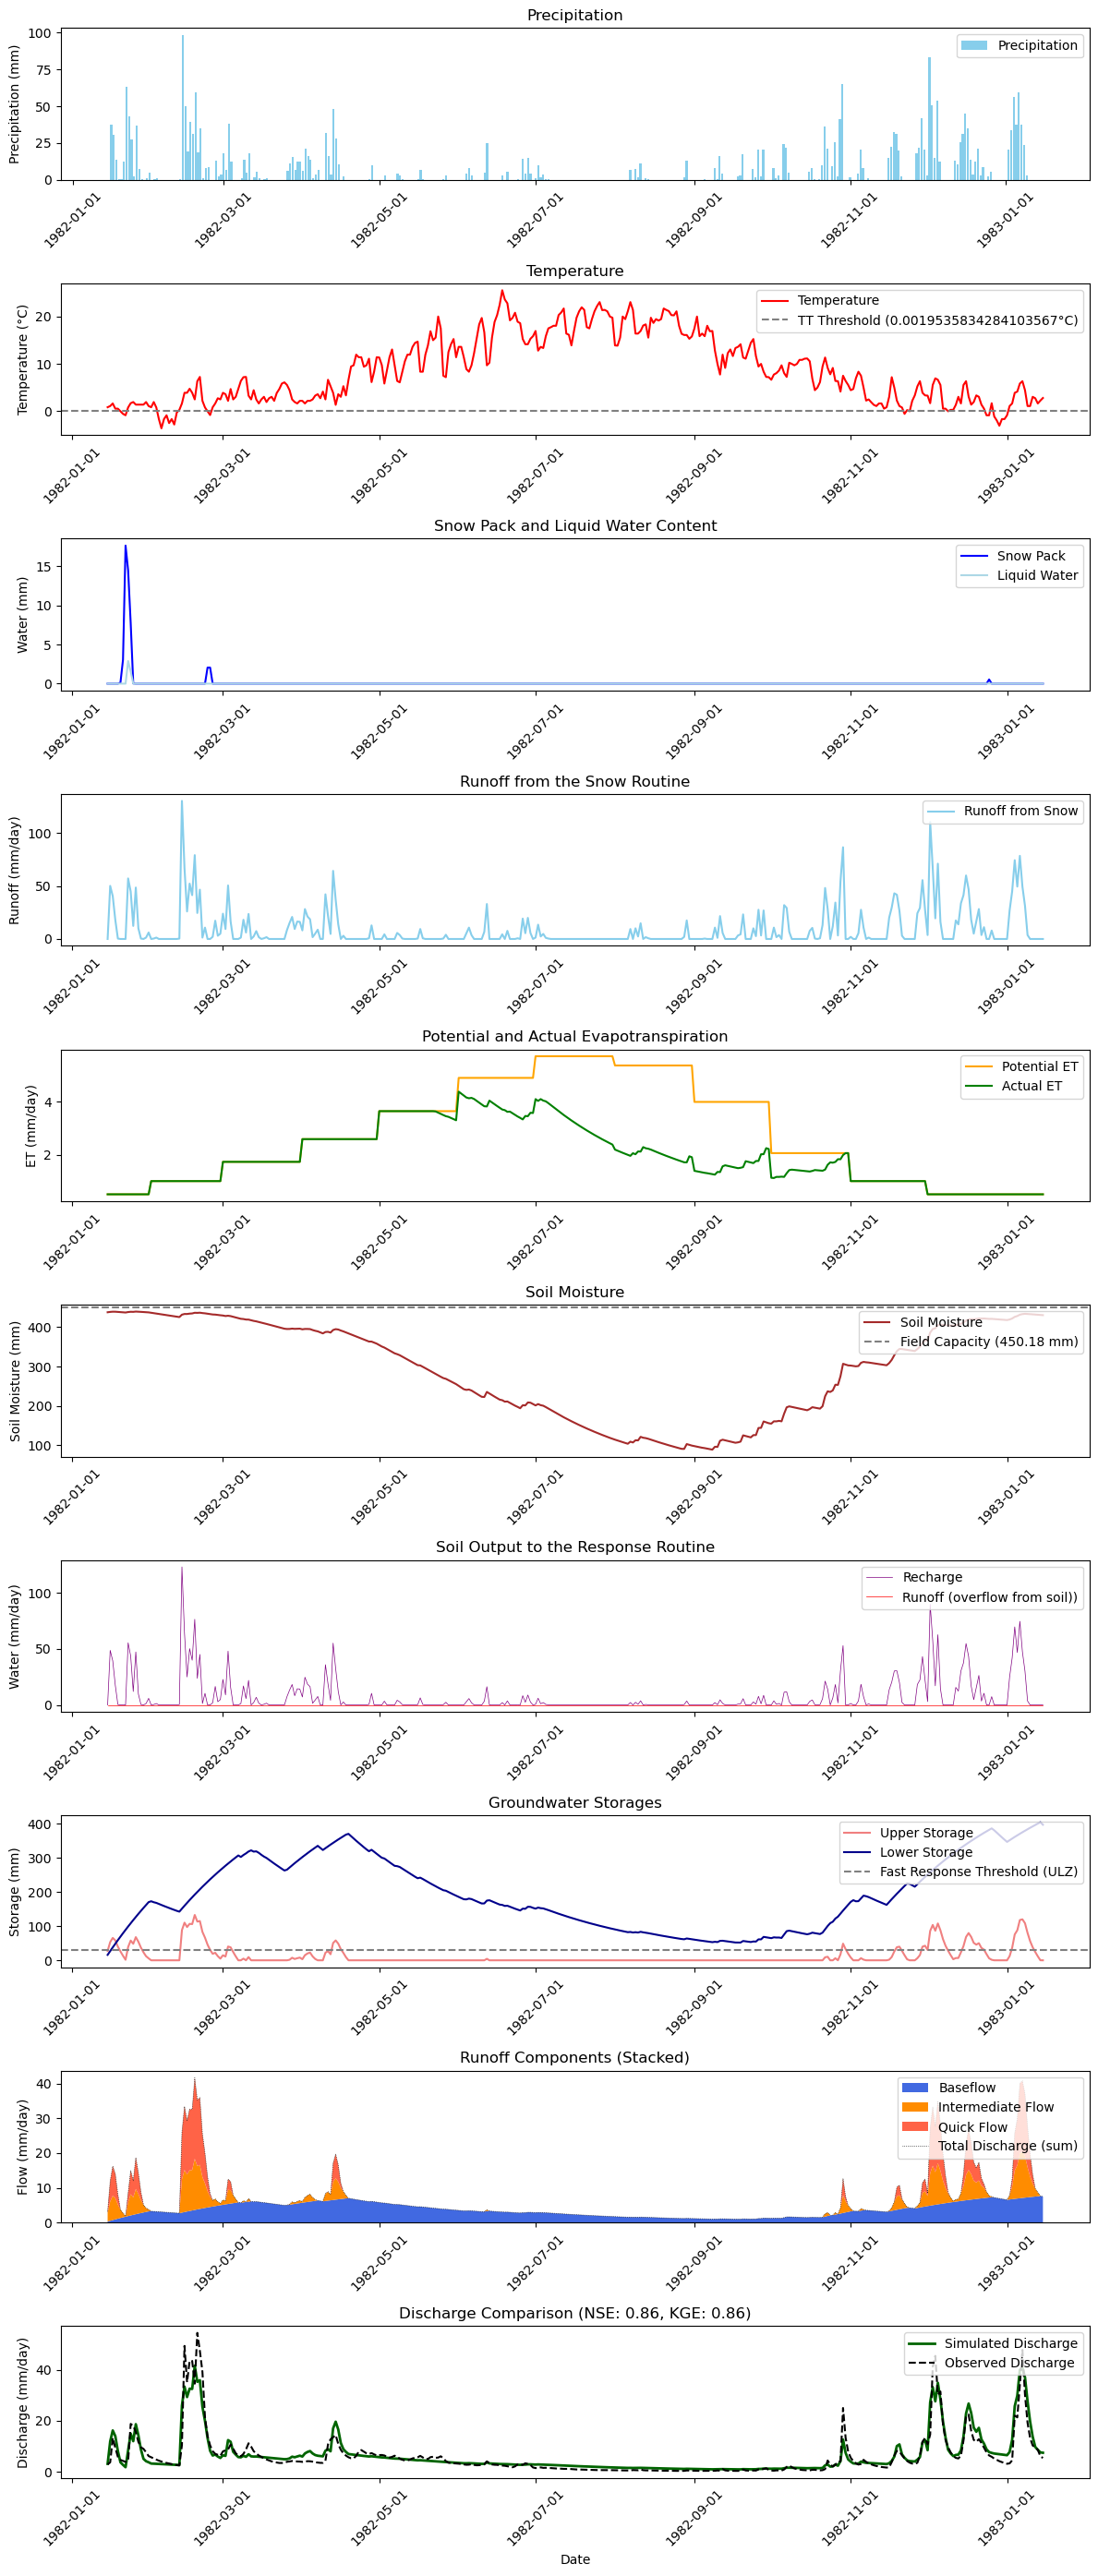

In [12]:
results = calibrate_hbv_model(
    model,
    method='SLSQP',     # Optimization algorithm
    objective='NSE',    # Objective function to optimize
    iterations=5000000,     # Maximum iterations
    verbose=True,       # Print progress
    plot_results=True   # Plot results after calibration
)

# The model now has calibrated parameters
# You can access them via model.params

# You can also access the calibration results
optimized_params = results['parameters']
performance = results['performance']
optimization_details = results['optimization_result']


In [9]:
cal_par= model.params
cal_par

{'response': {'K0': {'min': 0.01, 'max': 0.9, 'default': 0.2464570608296305},
  'K1': {'min': 0.05, 'max': 0.5, 'default': 0.13064641432716737},
  'K2': {'min': 0.005, 'max': 0.5, 'default': 0.04939801293306565},
  'UZL': {'min': 5.0, 'max': 50.0, 'default': 29.504239393111373},
  'PERC': {'min': 0.03, 'max': 25, 'default': 9.77471656034938}},
 'snow': {'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0019532455354606317},
  'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 1.9619716679393904},
  'PCF': {'min': 0.3, 'max': 1.5, 'default': 1.031139933870801},
  'SFCF': {'min': 0, 'max': 1.5, 'default': 0.7420395832334346},
  'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.06839852660086458},
  'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.0}},
 'soil': {'FC': {'min': 50.0, 'max': 650, 'default': 449.97399516381313},
  'LP': {'min': 0.3, 'max': 1.0, 'default': 1.0},
  'BETA': {'min': 1.0, 'max': 35, 'default': 1.0}}}

In [30]:
performance

{'NSE': 0.9126435653586553,
 'KGE': 0.8823810664350796,
 'PBIAS': 5.067602733997094,
 'r': 0.9577550413049972}

In [ ]:
custom_params_UBNB = {
    'snow': {
        'TT': {'min': -2.0, 'max': 2.0, 'default': 0.0},      # Temperature threshold for snow/rain (°C)
        'CFMAX': {'min': 1.0, 'max': 6.0, 'default': 4},      # Degree-day factor (mm/°C/day)
        'PCF': {'min': 0.3, 'max': 1.5, 'default': 0.67},      # Precipitation correction factor (-)
        'SFCF': {'min': 0, 'max': 1.5, 'default': 0.3},     # Snowfall correction factor (-)
        'CFR': {'min': 0.0, 'max': 0.2, 'default': 0.05},     # Refreezing coefficient (-)
        'CWH': {'min': 0.0, 'max': 0.2, 'default': 0.1}       # Water holding capacity of snow (-)
    },
    'soil': {
        'FC': {'min': 50.0, 'max': 650, 'default': 450.0},  # Field capacity (mm)
        'LP': {'min': 0.3, 'max': 1.0, 'default': 0.75},      # Limit for potential evaporation (-)
        'BETA': {'min': 1.0, 'max': 35, 'default': 3.0}      # Shape coefficient (-)
    },
    'response': {
        'K0': {'min': 0.01, 'max': 0.9, 'default': 0.12},      # Quick flow recession coefficient (1/day)
        'K1': {'min': 0.05, 'max': 0.5, 'default': 0.05},     # Intermediate flow recession coefficient (1/day)
        'K2': {'min': 0.005, 'max': 0.5, 'default': 0.05},     # Baseflow recession coefficient (1/day)
        'UZL': {'min': 5.0, 'max': 50.0, 'default': 28.0},    # Upper zone threshold (mm)
        'PERC': {'min': 0.03, 'max': 25, 'default': 0.25}     # Percolation rate (mm/day)
    }
}